# Выбор локации для скважины

Некоторой нефтедобывающей компании необходимо решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где были измерены качество нефти и объём её запасов. 
Необходимо: 
- Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.
- Проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных

**Признаки:**
- `id` - уникальный идентификатор скважины;
- `f0, f1, f2` - три признака точек;
- `product` - объём запасов в скважине (тыс. баррелей).

**Условия задачи:**
- Для обучения модели используем только линейную регрессию (остальные - недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе - 10 млрд. рублей.
- Пусть один баррель сырья приносит 450 рублей дохода. Доход от каждой единицы продукта составляет 450 тыс. рублей, так как объём указан в тыс. баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью. 

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import matplotlib as mpl

#Зададим RandomState, чтобы в последстии ответы можно было воспроизвести повторно
state = np.random.RandomState(1337)

In [2]:
data1 = pd.read_csv('geo_data_0.csv')
data2 = pd.read_csv('geo_data_1.csv')
data3 = pd.read_csv('geo_data_2.csv')

In [3]:
print(data1.info())
print('Дубликатов:', data1.duplicated().sum())
display(data1.describe())
data1.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
Дубликатов: 0


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


In [4]:
print(data2.info())
print('Дубликатов:', data2.duplicated().sum())
display(data2.describe())
data2.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
Дубликатов: 0


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


In [5]:
print(data3.info())
print('Дубликатов:', data3.duplicated().sum())
display(data3.describe())
data3.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
Дубликатов: 0


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


На первый взгляд, с данными всё в порядке:
- пустых значений нет;
- типы столбцов указаны правльно;
- дубликатов нет.

Поскольку, `id` - идентификатор скважины, он не должен влиять на предсказания модели. Удалим столбцы `id` из каждого DataFrame`a.

In [6]:
data1 = data1.drop(['id'], axis=1)
data2 = data2.drop(['id'], axis=1)
data3 = data3.drop(['id'], axis=1)

## Обучение и проверка модели

Для начала разобьём данные на обучающую и валидационную выборки в соотношении 75:25. Создадим для каждой скважины переменные `features_train`, `features_valid`, `target_train`, `target_valid`.

In [7]:
(features_train1, features_valid1, target_train1, target_valid1, 
 features_train2, features_valid2, target_train2, target_valid2, 
 features_train3, features_valid3, target_train3, target_valid3) = train_test_split(data1.drop(['product'], axis=1),
                                                                                    data1['product'],
                                                                                    data2.drop(['product'], axis=1),
                                                                                    data2['product'],
                                                                                    data3.drop(['product'], axis=1),
                                                                                    data3['product'],
                                                                                    test_size=0.25,
                                                                                    random_state=state)

Обучим модель линейной регрессии и сделаем предсказания на валидационной выборке. Для этого создадим функцию `modeling`.

In [8]:
def modeling(features_train, features_valid, target_train, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    pred_mean = round(predictions.mean(), 3)
    rmse = round(mean_squared_error(target_valid, predictions) ** 0.5, 3)
    print('Оценка модели R2:', round(model.score(features_valid, target_valid), 3))
    print('Средняя оценка кросс-валидации:', round(cross_val_score(model, 
                                                                   pd.concat([features_train, features_valid]), 
                                                                   pd.concat([target_train, target_valid])).mean(), 3))
    print('Среднее из предсказанного:', pred_mean)
    print('Среднеквадратическое отклонение (RMSE):', rmse)
    print('Реальное среднее:', round(target_valid.mean(), 3))

### Скважина первого региона

In [9]:
modeling(features_train1, features_valid1, target_train1, target_valid1)

Оценка модели R2: 0.27
Средняя оценка кросс-валидации: 0.276
Среднее из предсказанного: 92.416
Среднеквадратическое отклонение (RMSE): 37.829
Реальное среднее: 92.22


### Скважина второго региона

In [10]:
modeling(features_train2, features_valid2, target_train2, target_valid2)

Оценка модели R2: 1.0
Средняя оценка кросс-валидации: 1.0
Среднее из предсказанного: 68.673
Среднеквадратическое отклонение (RMSE): 0.881
Реальное среднее: 68.678


### Скважина третьего региона

In [11]:
modeling(features_train3, features_valid3, target_train3, target_valid3)

Оценка модели R2: 0.196
Средняя оценка кросс-валидации: 0.199
Среднее из предсказанного: 94.971
Среднеквадратическое отклонение (RMSE): 40.217
Реальное среднее: 95.154


**Промежуточный вывод:** 
- точность модели для первого и третьего регионов слишком низкая;
- точно второго региона равна 100%, потрясающий результат;
- среднеквадратическое отклонение для первого и третьего регионов велико, относительного второго региона;
- объёмы сырья в первом и третьем регионе почти в 1.5 раза больше объёмов сырья во втором регионе.

## Подготовка к расчёту прибыли

**Зададим константы.**

In [12]:
BUDGET = 10000000000
INCOME = 450
POOL = 500
POOL_BEST = 200

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

In [13]:
MIN_BARRS_COUNT = BUDGET / (INCOME * POOL_BEST)

In [14]:
print('Достаточный объём сырья в скавиже для безубыточной разработки:', round(MIN_BARRS_COUNT/1000), 'тыс.')

Достаточный объём сырья в скавиже для безубыточной разработки: 111 тыс.


Это больше среднего значения в любом из регионов. Поскольку компания планирует исследовать 500 точек, из которых выбрать 200 лучших скважин для разработки, посмотрим на среднее значение объёма запасов 200 скважин с наибольшим показателем `product` в выборках из 500 скважин в каждом регионе.

In [16]:
def top200(data):
    return data.sample(n=500, random_state=state).sort_values(by='product', ascending=False)[:200]['product'].mean()

In [18]:
print('Регион 1:', round(top200(data1), 3), 'тыс.')
print('Регион 2:', round(top200(data2), 3), 'тыс.')
print('Регион 3:', round(top200(data3), 3), 'тыс.')

Регион 1: 139.077 тыс.
Регион 2: 115.238 тыс.
Регион 3: 140.009 тыс.


**Промежуточный вывод:**
На основе полученных результатов видно, что в выборках из 500 точек в каждом регионе 200 лучших точек будут окупаться. Однако окупаемость в регионах 1 и 3 составит примерно 25%, тогда как во втором регионе - примерно 3%. Исходя из этого можно предположить, что рассмотрение полностью случайного отбора может увеличить риск убытков, если выбранные скважины не будут давать необходимый объём нефти.

## Расчёт прибыли и рисков 

**Функция для расчёта прибыли по выбранным скважинам:**

In [19]:
def profit(predictions, target):
    return target[predictions.sample(n=500, random_state=state).sort_values(ascending=False).index][:200].sum() * INCOME * 1000 - BUDGET

**Функция для нахождения распределения прибыли с помощью бутстрепа.**
- На вход функции подаётся DataFrame региона.
- Функция возвращает среднюю прибыль, 95%-й доверительный интервал, риск убытков.

In [20]:
def bootstrap(data):
    features_train, features_valid, target_train, target_valid = train_test_split(data.drop(['product'], axis=1),
                                                                                  data['product'],
                                                                                  test_size=0.25,
                                                                                  random_state=state)
    
    target_valid = target_valid.reset_index(drop=True)
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = pd.Series(model.predict(features_valid))
    
    values = []
    for i in range(1000):
        values.append(profit(predictions, target_valid))
    values = pd.Series(values)

    #данные для графика
    intervals['lower'].append(values.quantile(0.025))
    intervals['upper'].append(values.quantile(0.975))
    
    return (round(values.mean() / 1000000000, 3), 
            round(values.quantile(0.025) / 1000000000, 3), 
            round(values.quantile(0.975) / 1000000000, 3), 
            round(values[values < 0].shape[0] / values.shape[0] * 100, 3))

Далее посмтроим график, а сейчас соберём для него необходимые данные.

In [21]:
intervals = {
    'region': [1, 2, 3],
    'lower': [],
    'upper': [],
    'breakeven_point': 0,
}

### Первый регион

In [22]:
print('Средняя прибыль: {0[0]} млрд. рублей \n95%-й доверительный интервал: ({0[1]}, {0[2]}) \nВероятность убытков: {0[3]}%'.format(bootstrap(data1)))

Средняя прибыль: 0.421 млрд. рублей 
95%-й доверительный интервал: (-0.085, 0.907) 
Вероятность убытков: 4.8%


### Второй регион

In [23]:
print('Средняя прибыль: {0[0]} млрд. рублей \n95%-й доверительный интервал: ({0[1]}, {0[2]}) \nВероятность убытков: {0[3]}%'.format(bootstrap(data2)))

Средняя прибыль: 0.417 млрд. рублей 
95%-й доверительный интервал: (0.035, 0.841) 
Вероятность убытков: 1.4%


### Третий регион

In [24]:
print('Средняя прибыль: {0[0]} млрд. рублей \n95%-й доверительный интервал: ({0[1]}, {0[2]}) \nВероятность убытков: {0[3]}%'.format(bootstrap(data3)))

Средняя прибыль: 0.373 млрд. рублей 
95%-й доверительный интервал: (-0.14, 0.888) 
Вероятность убытков: 8.0%


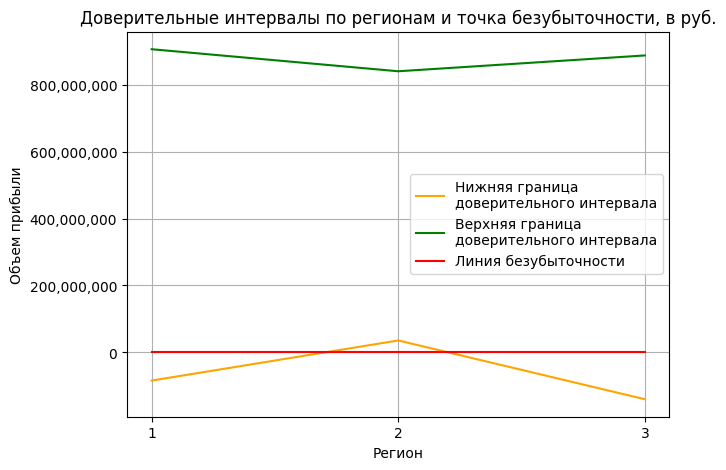

In [25]:
# Отобразим на графике доверительные интервалы по регионам с точкой безубыточности
ax = pd.DataFrame(intervals).plot(
    kind='line',
    x='region',
    y=['lower', 'upper', 'breakeven_point'],
    grid=True,
    style={'lower': 'orange', 'upper': 'g', 'breakeven_point': 'r'},
    figsize=(7, 5),
    title='Доверительные интервалы по регионам и точка безубыточности, в руб.'
)

plt.ylabel('Объем прибыли')
plt.xlabel('Регион')
plt.xticks(range(1, 4))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend(['Нижняя граница\nдоверительного интервала', 'Верхняя граница\nдоверительного интервала', 'Линия безубыточности'])
plt.show()

## Общий вывод

Взяты базы данных по трем регионам по характеристикам скважин: признаки (`f1`, `f2`, `f3`) и целевым признаком - объемом запасов (`product`). Для эффективного обучения модели линейной регрессии удалем столбец `id`, так как почти все объекты уникальны. Далее для каждого из регионов были созданы отдельные тестовые и валидационные выборки, на основе которых и осуществлялось обучение моделей линейной регрессии.

Компания при разведке региона использует случайные 500 скважин по каждому из регионов, из которых с помощью машинного обучения выбирают 200 лучших по объема запасов нефти. Расчет среднего показателя объема запасов хоть и превосходил точку безубыточности для каждого из регионов, однако, например, для **Региона 2** лишь на 4 тыс. Далее были рассмотрены показатели с помощью техники бутстреп, рассчитав при этом следующие показатели: 95%-й доверительный интервал (2.5% и 97.5% - квантили), среднее объем прибыли, а также риск убытков. 

В конечном итоге получились следующие значения для каждого из регионов:

**Регион 1:**
- средняя прибыль: 0.421 млрд. рублей;
- доверительный интервал (в млрд. руб.): (-0.085, 0.907);
- вероятность убытков: 4.6%.

**Регион 2:**
- средняя прибыль: 0.417 млрд. рублей;
- доверительный интервал (в млрд. руб.): (0.035, 0.841);
- вероятность убытков: 1.4%.

**Регион 3:**
- средняя прибыль: 0.373 млрд. рублей;
- доверительный интервал (в млрд. руб.): (-0.14, 0.888);
- вероятность убытков: 8.0%.

Проанализировав значения необходимых показателей, можно сделать вывод, что наиболее привлекательным регионом для разработки скважин нефти будет **Регион 2**, поскольку даже 2.5%-квантиль имеет положительное значение, а также риск убытков удовлетворяет необходимому требования - менее 2.5%. Хоть **Регион 1** и **Регион 3** потенциально могут принести большую прибыл, они слишком непредсказуемы и вероятность убытков в них велика. 

**Рекомендация:** В соответствии с вышеизложенными выводами, логично начать разработку скважин в **Регионе 2**, учитывая и низкий риск убытков (1.4%: что ниже необходимого максимума в 2.5%), и возможность получения прибыли довольно большого объема прибыли (примерно 400 млн руб. в среднем).